In [1]:
# 필요 패키지 설치 -> 이미 설치되어 있음
#!pip install sentencepiece

In [2]:
# 라이브러리 불러오기
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib as plt
import konlpy
import os

print(tf.__version__)
print(pd.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.3.3
1.21.4
3.4.3
0.5.2


In [3]:
# 디렉토리 확인
!ls

korean_spm.model  ratings_test.txt   README.md
korean_spm.vocab  ratings_train.txt  sentencepiece.ipynb


### 1. 학습/테스트 데이터 준비

In [4]:
# 데이터 불러오기
train_data = pd.read_csv("ratings_train.txt", sep='\t')
test_data = pd.read_csv("ratings_test.txt", sep='\t')
print(train_data.head())
print(test_data.head())
print(f'학습 데이터 크기: {len(train_data)}')
print(f'테스트 데이터 크기: {len(test_data)}')

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
        id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0
학습 데이터 크기: 150000
테스트 데이터 크기: 50000


In [5]:
# 문자열이 아닌 경우 제거
train_data = train_data.dropna()
test_data = test_data.dropna()
print(f'에러 제거 후 학습 데이터 크기: {len(train_data)}')
print(f'에러 제거 후 테스트 데이터 크기: {len(test_data)}')

에러 제거 후 학습 데이터 크기: 149995
에러 제거 후 테스트 데이터 크기: 49997


In [6]:
# 중복 제거
train_data = train_data.drop_duplicates(subset='document')
test_data = test_data.drop_duplicates(subset='document')
print(f'중복 제거 후 학습 데이터 크기: {len(train_data)}')
print(f'중복 제거 후 테스트 데이터 크기: {len(test_data)}')

중복 제거 후 학습 데이터 크기: 146182
중복 제거 후 테스트 데이터 크기: 49157


### 2. SentencePiece 학습

In [15]:
import sentencepiece as spm
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [16]:
# 학습용 파일 읽어오기
train_file_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(train_file_path, "r") as f:
    raw = f.read().splitlines()

print(f'학습용 데이터의 문장(줄) 수: {len(raw)}')

학습용 데이터의 문장(줄) 수: 94123


In [17]:
# 중복 제거
raw = list(set(raw))

print(f'중복 제거된 문장(줄) 수: {len(raw)}')

중복 제거된 문장(줄) 수: 77591


In [18]:
# 예제 확인
print("Example:")
for sentence in raw[0:100][::20]:
    print(">>", sentence)

Example:
>> 오마바 의원의 아버지는 1982년 케냐 나이로비에서 교통사고로 사망했다.
>> 한편 문제의 사진은 자동차 안에서 촬영됐으며 사진의 배경이 된 모로코 여성은 여자 아이를 등에 업고 도로를 따라 이동한 것으로 알려졌다.
>> 어빙은 “많은 사람들이 휴대폰, 아이팟, 무선 컴퓨터를 사용하면서 자신들만의 작은 세상에 갇혀있다”며 “그들은 사회에 존재하지 않는 부류의 사람”이라고 지적했다.
>> 현재 폐경 이후 여성들 사이 에서 심장질환에 의한 사망률이 빠르게 증가하고 있다.
>> 하우저는 “이제 무언가 자리가 잡히는 느낌이었는데 파업이라는 변수를 만났다”며 “사태가 30일~45일안에 해결되길 바란다”고 덧붙였다.


In [19]:
# 문장 길이 관련 통계 정보
min_len = 9999
max_len = 0
sum_len = 0

for sentence in raw:
    length = len(sentence)
    if min_len > length:
        min_len = length
    if max_len < length:
        max_len = length
    sum_len += length

print(f"문장의 최단 길이: {min_len}")
print(f"문장의 최장 길이: {max_len}")
print(f"문장의 평균 길이: {sum_len // len(raw)}")

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


In [20]:
# 특정 길이를 갖는 문장을 출력 (최대 10개)
def check_sentence_with_length(raw, length):
    count = 0

    for sentence in raw:
        if len(sentence) == length:
            count += 1
            if count < 10:
                print(sentence)
    print(f"길이가 {length}인 문장의 수: {count}")

In [21]:
check_sentence_with_length(raw, 2)

2.
1.
음식
..
과일
면접
햇빛
3.
4.
길이가 2인 문장의 수: 12


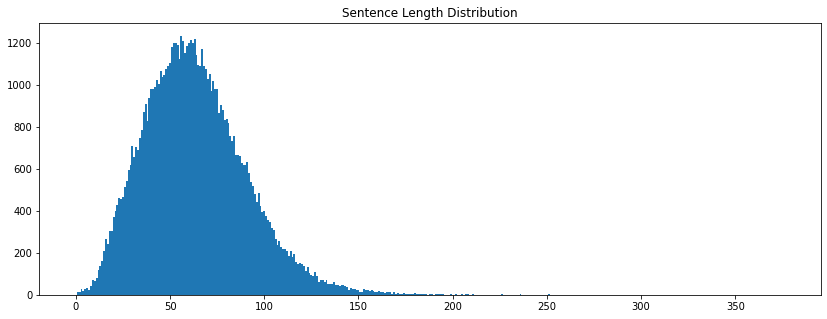

In [23]:
# 문장 길이별 분포도
sentence_length = np.zeros((max_len), dtype=int)

for sentence in raw:
    sentence_length[len(sentence) - 1] += 1

plt.figure(figsize=(14,5))
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [24]:
# 길이 조건에 맞는 문장만 선택
max_len = 150
min_len = 10

filtered_corpus = [s for s in raw if (len(s) < max_len) & (len(s) >= min_len)]

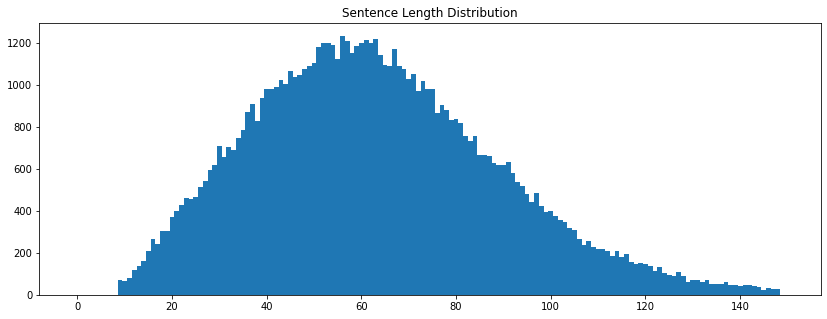

In [26]:
# 문장 길이별 분포도
sentence_length = np.zeros((max_len), dtype=int)

for sentence in filtered_corpus:
    sentence_length[len(sentence) - 1] += 1

plt.figure(figsize=(14,5))
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [27]:
# 정제된 corpus를 임시 파일로 저장
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

with open(temp_file, 'w') as f:
    for row in filtered_corpus:
        f.write(str(row) + '\n')

In [28]:
# SentencePiece 학습
VOCAB_SIZE = 8000

spm.SentencePieceTrainer.Train('--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, VOCAB_SIZE))
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

In [29]:
# 결과 확인
!ls -l korean_spm*

-rw-r--r-- 1 root root 376816 Feb 25 05:24 korean_spm.model
-rw-r--r-- 1 root root 146213 Feb 25 05:24 korean_spm.vocab


In [30]:
# 토크나이저 테스트
tokenizer = spm.SentencePieceProcessor()
tokenizer.Load('korean_spm.model')

# 문장 인코딩
tokensIDs = tokenizer.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# 문장 토크화 결과
print(tokenizer.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# 문장 복원
print(tokenizer.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


### 3. 모델 학습용 데이터 준비

In [40]:
# 문장 리스트에 대해 토큰화
def sp_tokenize(tokenizer, corpus): 
    tensor = []

    for sentence in corpus:
        try:
            tensor.append(tokenizer.EncodeAsIds(sentence))
        except:
            print(sentence)

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [41]:
# 학습/테스트 데이터 토큰화
train_x, word_index_train, index_word_train = sp_tokenize(tokenizer, train_data['document'])
test_x, word_index_test, index_word_test = sp_tokenize(tokenizer, test_data['document'])

In [42]:
print(train_x.shape, len(word_index_train), len(index_word_train))
print(test_x.shape, len(word_index_test), len(index_word_test))

(146182, 140) 8000 8000
(49157, 140) 8000 8000


In [43]:
# 학습/테스트 데이터 레이블
train_y = train_data['label']
test_y = test_data['label']

train_y = np.array(train_y)
test_y = np.array(test_y)

In [44]:
# 데이터셋 분리
validation_size = 30000
validation_x = train_x[:validation_size]
validation_y = train_y[:validation_size]

# Train Set 조정
partial_train_x = train_x[validation_size:]  
partial_train_y = train_y[validation_size:]

print(partial_train_x.shape, partial_train_y.shape, validation_x.shape, validation_y.shape)

(116182, 140) (116182,) (30000, 140) (30000,)


### 4. 딥러닝 모델

In [62]:
# 모델 구성 - LSTM
EMBEDDING_DIM = 256
LSTM_DIM = 128
DENSE_DIM = 64
DROPOUT = 0.1

lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM, input_shape=(None,)))
lstm_model.add(tf.keras.layers.LSTM(LSTM_DIM))
lstm_model.add(tf.keras.layers.Dense(DENSE_DIM, activation='relu'))
lstm_model.add(tf.keras.layers.Dropout(DROPOUT))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 256)         2048000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 2,253,441
Trainable params: 2,253,441
Non-trainable params: 0
_________________________________________________________________


In [63]:
# 모델 학습 구성
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
best_model_check = tf.keras.callbacks.ModelCheckpoint(filepath='nsmc_lstm.keras', monitor='val_loss', save_best_only=True)

EPOCHS = 10
BATCH_SIZE = 512

In [64]:
# 학습
lstm_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lstm_history = lstm_model.fit(partial_train_x, partial_train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(validation_x, validation_y), callbacks=best_model_check)

Epoch 1/10
227/227 [==============================] - 11s 41ms/step - loss: 0.4207 - accuracy: 0.8071 - val_loss: 0.3536 - val_accuracy: 0.8417
Epoch 2/10
227/227 [==============================] - 9s 38ms/step - loss: 0.3289 - accuracy: 0.8575 - val_loss: 0.3453 - val_accuracy: 0.8451
Epoch 3/10
227/227 [==============================] - 9s 38ms/step - loss: 0.2897 - accuracy: 0.8776 - val_loss: 0.3469 - val_accuracy: 0.8488
Epoch 4/10
227/227 [==============================] - 9s 39ms/step - loss: 0.2603 - accuracy: 0.8922 - val_loss: 0.3508 - val_accuracy: 0.8486
Epoch 5/10
227/227 [==============================] - 9s 39ms/step - loss: 0.2397 - accuracy: 0.9026 - val_loss: 0.3681 - val_accuracy: 0.8468
Epoch 6/10
227/227 [==============================] - 9s 39ms/step - loss: 0.2286 - accuracy: 0.9077 - val_loss: 0.3654 - val_accuracy: 0.8466
Epoch 7/10
227/227 [==============================] - 9s 40ms/step - loss: 0.2205 - accuracy: 0.9105 - val_loss: 0.3891 - val_accuracy: 0.845

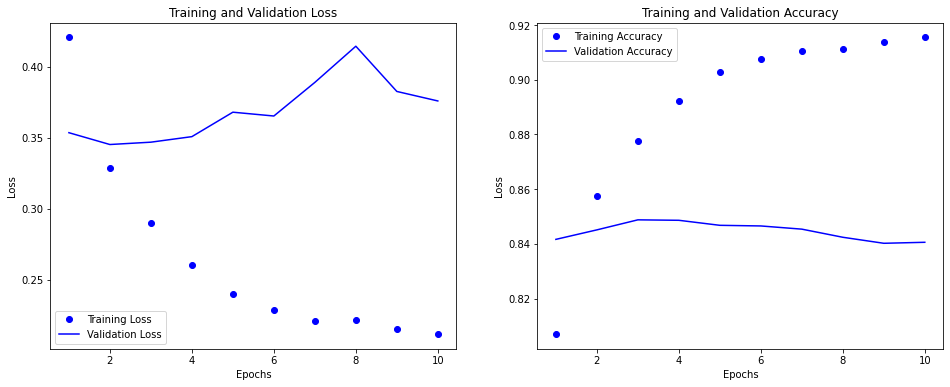

In [65]:
# 시각화
import matplotlib.pyplot as plt

acc = lstm_history.history['accuracy']
val_acc = lstm_history.history['val_accuracy']
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [68]:
# 테스트 데이터를 이용한 평가
best_model = tf.keras.models.load_model("nsmc_lstm.keras")
loss, accuracy = best_model.evaluate(test_x, test_y)
print(f'Loss: {loss:.6f}, Accuracy: {accuracy:.6f}')

1537/1537 [==============================] - 6s 4ms/step - loss: 0.3511 - accuracy: 0.8439
Loss: 0.3511, Accuracy: 0.8439
